Columns in caserne_with_grid: Index(['CASERNE', 'NO_CIVIQUE', 'RUE', 'LATITUDE', 'LONGITUDE',
       'ARRONDISSEMENT', 'VILLE', 'DATE_DEBUT', 'DATE_FIN', 'MTM8_X', 'MTM8_Y',
       'geometry', 'index_right', 'FEUILLET'],
      dtype='object')
Columns in fires_with_grid: Index(['INCIDENT_NBR', 'CREATION_DATE', 'INCIDENT_TYPE_DESC',
       'DESCRIPTION_GROUPE', 'CASERNE', 'NOM_VILLE', 'NOM_ARROND', 'DIVISION',
       'LATITUDE', 'LONGITUDE', 'NOMBRE_UNITES', 'DESC_GROUP_ENGLISH',
       'geometry', 'index_right', 'FEUILLET'],
      dtype='object')
📊 Pearson Correlation (Fire Stations vs. Fire Incidents): 0.6891 (p-value: 0.0000)


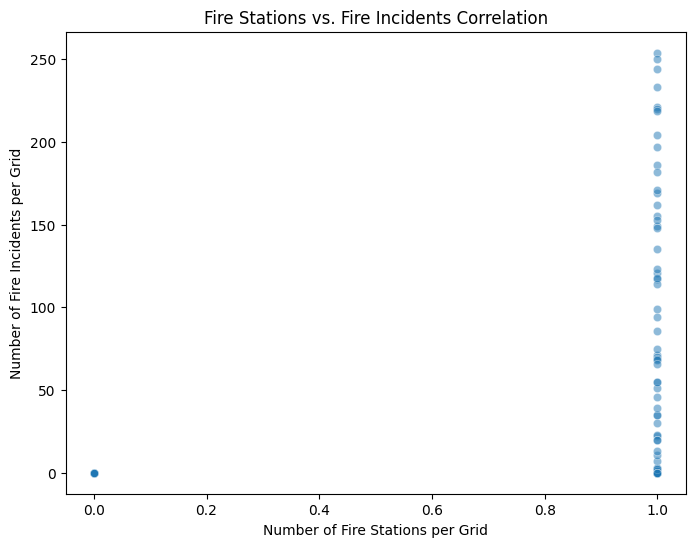

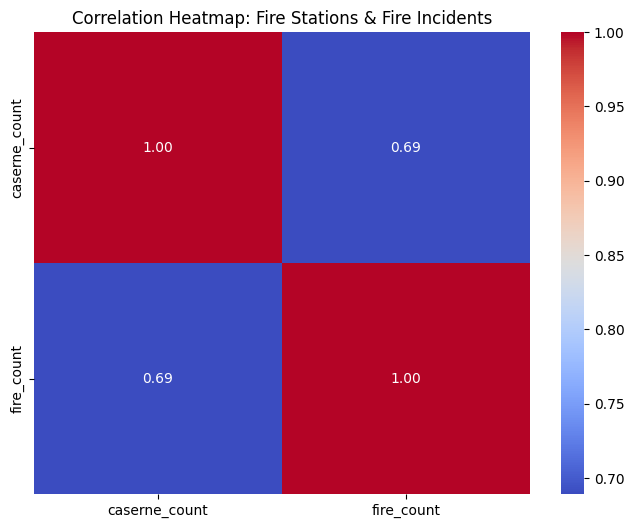

                            OLS Regression Results                            
Dep. Variable:             fire_count   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     807.5
Date:                Wed, 12 Feb 2025   Prob (F-statistic):          4.92e-127
Time:                        19:14:02   Log-Likelihood:                -4043.9
No. Observations:                 895   AIC:                             8092.
Df Residuals:                     893   BIC:                             8101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.843e-16      0.772   1.27e-15

In [ ]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.stats import pearsonr
import statsmodels.api as sm

# Load Fire Station (Caserne) and Fire Incident Datasets
caserne_file = "/content/casernes (1).csv"
fire_file = "/content/incidents-clean.csv"
grid_file = "/content/sqrc_1000 (1).geojson"

df_caserne = pd.read_csv(caserne_file)
df_fires = pd.read_csv(fire_file)
grid_gdf = gpd.read_file(grid_file)

# Drop rows with missing latitude/longitude before spatial analysis
df_caserne = df_caserne.dropna(subset=["LATITUDE", "LONGITUDE"])
df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])

# Convert to GeoDataFrames
df_caserne["geometry"] = df_caserne.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_caserne_gdf = gpd.GeoDataFrame(df_caserne, geometry="geometry", crs="EPSG:4326")

df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Spatial Join: Assign Fire Stations and Fire Incidents to Grid Squares
caserne_with_grid = gpd.sjoin(df_caserne_gdf, grid_gdf, how="left", predicate="within")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="within")

# Debug: Print column names to verify index_right existence
print(f"Columns in caserne_with_grid: {caserne_with_grid.columns}")
print(f"Columns in fires_with_grid: {fires_with_grid.columns}")

# Rename `index_right` if it exists, otherwise use the index
if "index_right" in caserne_with_grid.columns:
    caserne_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)
if "index_right" in fires_with_grid.columns:
    fires_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)

# Aggregate Data: Number of Fire Stations & Fire Incidents per Grid
caserne_counts = caserne_with_grid.groupby("grid_id").size().rename("caserne_count").reset_index()
fire_counts = fires_with_grid.groupby("grid_id").size().rename("fire_count").reset_index()

# Merge Data with Grid Using Correct Indexing
grid_gdf = grid_gdf.merge(caserne_counts, left_index=True, right_on="grid_id", how="left")
grid_gdf = grid_gdf.merge(fire_counts, left_index=True, right_on="grid_id", how="left")

# Fill NaN values (some grids may have no fire stations or fires)
grid_gdf["caserne_count"] = grid_gdf["caserne_count"].fillna(0)
grid_gdf["fire_count"] = grid_gdf["fire_count"].fillna(0)

# Compute Correlation
correlation, p_value = pearsonr(grid_gdf["caserne_count"], grid_gdf["fire_count"])
print(f"📊 Pearson Correlation (Fire Stations vs. Fire Incidents): {correlation:.4f} (p-value: {p_value:.4f})")

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=grid_gdf["caserne_count"], y=grid_gdf["fire_count"], alpha=0.5)
plt.xlabel("Number of Fire Stations per Grid")
plt.ylabel("Number of Fire Incidents per Grid")
plt.title("Fire Stations vs. Fire Incidents Correlation")
plt.show()

# Heatmap of Fire Station vs. Fire Incidents Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(grid_gdf[["caserne_count", "fire_count"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Fire Stations & Fire Incidents")
plt.show()

# Regression Analysis: Do More Fire Stations Predict More/Fewer Fire Incidents?
X = grid_gdf["caserne_count"]
y = grid_gdf["fire_count"]
X = sm.add_constant(X)  # Add intercept

model = sm.OLS(y, X).fit()
print(model.summary())

📊 T-Test: t-stat = 1.2945, p-value = 0.2033
                            OLS Regression Results                            
Dep. Variable:          NOMBRE_UNITES   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.03
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           1.34e-06
Time:                        19:17:48   Log-Likelihood:                -55435.
No. Observations:               15897   AIC:                         1.109e+05
Df Residuals:                   15893   BIC:                         1.109e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

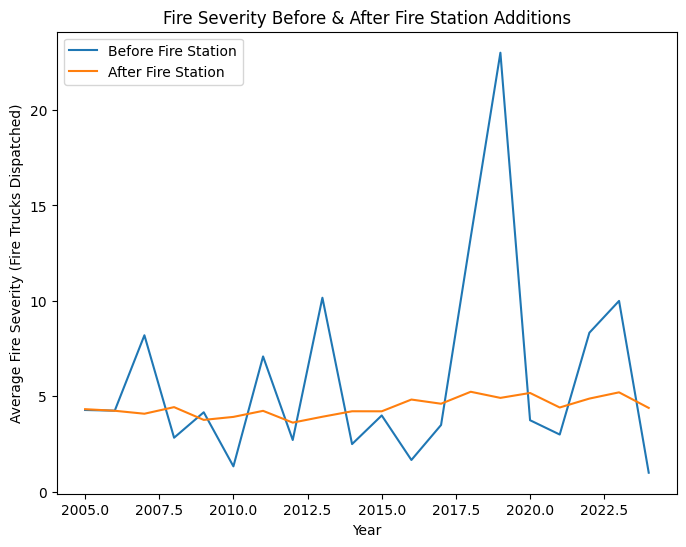

In [ ]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load Data
caserne_file = "/content/casernes (1).csv"  # Update with correct file path
fire_file = "/content/incidents-clean.csv"
grid_file = "/content/sqrc_1000 (1).geojson"

df_caserne = pd.read_csv(caserne_file)
df_fires = pd.read_csv(fire_file)
grid_gdf = gpd.read_file(grid_file)

# Drop rows with missing coordinates
df_caserne = df_caserne.dropna(subset=["LATITUDE", "LONGITUDE"])
df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])

# Convert to GeoDataFrames
df_caserne["geometry"] = df_caserne.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_caserne_gdf = gpd.GeoDataFrame(df_caserne, geometry="geometry", crs="EPSG:4326")

df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Spatial Join: Assign Fire Stations and Fire Incidents to Grid Squares
caserne_with_grid = gpd.sjoin(df_caserne_gdf, grid_gdf, how="left", predicate="within")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="within")

# Assign Year of Fire Incident
fires_with_grid["YEAR"] = pd.to_datetime(fires_with_grid["CREATION_DATE"]).dt.year

# Count Fire Stations per Grid per Year
caserne_with_grid["YEAR"] = pd.to_datetime(caserne_with_grid["DATE_DEBUT"]).dt.year
caserne_per_year = caserne_with_grid.groupby(["index_right", "YEAR"]).size().unstack(fill_value=0)

# Identify Grids That Gained a Fire Station
caserne_per_year["station_added"] = caserne_per_year.diff(axis=1).gt(0).any(axis=1)

# Aggregate Fire Severity Before & After Fire Station Additions
fires_with_grid = fires_with_grid.merge(caserne_per_year["station_added"], left_on="index_right", right_index=True, how="left")

# Compute Average Fire Severity Before & After
before = fires_with_grid[fires_with_grid["station_added"] == False].groupby("YEAR")["NOMBRE_UNITES"].mean()
after = fires_with_grid[fires_with_grid["station_added"] == True].groupby("YEAR")["NOMBRE_UNITES"].mean()

# Perform T-Test to Check If Fire Severity Significantly Changed
t_stat, p_value = ttest_ind(before, after, nan_policy="omit")
print(f"📊 T-Test: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")

# Difference-in-Differences (DiD) Analysis
fires_with_grid["post"] = fires_with_grid["YEAR"] > fires_with_grid["YEAR"].median()  # Define pre/post period
model = smf.ols("NOMBRE_UNITES ~ station_added * post", data=fires_with_grid).fit()
print(model.summary())

# Plot Fire Severity Over Time
plt.figure(figsize=(8,6))
sns.lineplot(x=before.index, y=before.values, label="Before Fire Station")
sns.lineplot(x=after.index, y=after.values, label="After Fire Station")
plt.xlabel("Year")
plt.ylabel("Average Fire Severity (Fire Trucks Dispatched)")
plt.title("Fire Severity Before & After Fire Station Additions")
plt.legend()
plt.show()


<Figure size 1000x1000 with 0 Axes>

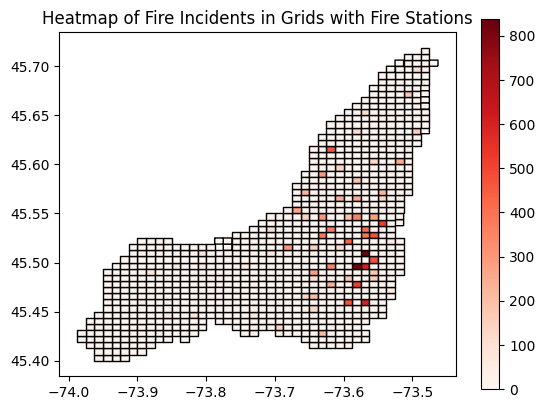

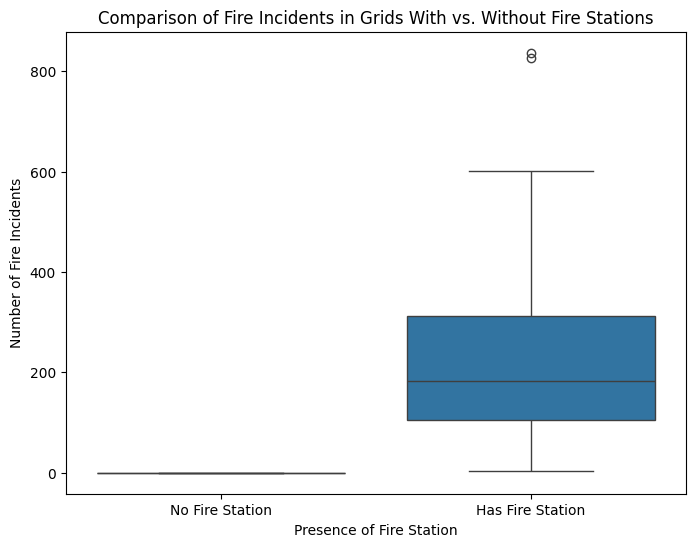

<ipython-input-7-978b314f8b3a>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_fires.index, y=avg_fires.values, palette=["blue", "red"])


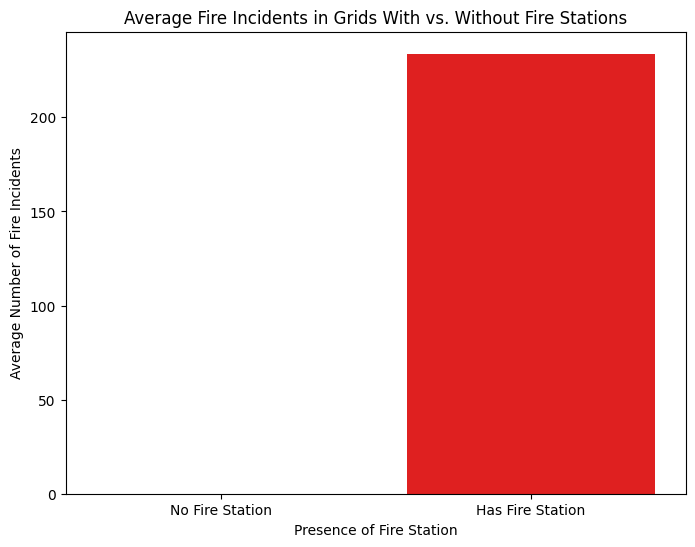

In [ ]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Define file paths
fire_file = "/content/incidents-clean.csv"
caserne_file = "/content/casernes (1).csv"
grid_file = "/content/sqrc_1000 (1).geojson"

# Load the datasets
df_fires = pd.read_csv(fire_file)
df_caserne = pd.read_csv(caserne_file)
grid_gdf = gpd.read_file(grid_file)

# Drop missing lat/lon values
df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])
df_caserne = df_caserne.dropna(subset=["LATITUDE", "LONGITUDE"])

# Convert to GeoDataFrames
df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

df_caserne["geometry"] = df_caserne.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_caserne_gdf = gpd.GeoDataFrame(df_caserne, geometry="geometry", crs="EPSG:4326")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Spatial Join: Assign Fire Stations and Fire Incidents to Grid Squares
caserne_with_grid = gpd.sjoin(df_caserne_gdf, grid_gdf, how="left", predicate="within")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="within")

# Rename `index_right` if it exists
if "index_right" in caserne_with_grid.columns:
    caserne_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)
if "index_right" in fires_with_grid.columns:
    fires_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)

# Aggregate Data: Count Fire Incidents Per Grid That Has a Fire Station
caserne_grids = caserne_with_grid["grid_id"].unique()  # Grids that have fire stations
fire_counts = fires_with_grid[fires_with_grid["grid_id"].isin(caserne_grids)].groupby("grid_id").size().rename("fire_count").reset_index()

# Merge Fire Incident Data with Grid
grid_gdf = grid_gdf.merge(fire_counts, left_index=True, right_on="grid_id", how="left")

# Fill missing values (some grids may have no fire incidents)
grid_gdf["fire_count"] = grid_gdf["fire_count"].fillna(0)

#  **HEATMAP: Fire Incidents in Grids with Fire Stations**
plt.figure(figsize=(10, 10))
grid_gdf.plot(column="fire_count", cmap="Reds", edgecolor="black", legend=True)
plt.title("Heatmap of Fire Incidents in Grids with Fire Stations")
plt.show()

#  **BOX PLOT: Comparing Fire Incidents in Grids With vs. Without Fire Stations**
grid_gdf["has_fire_station"] = grid_gdf["grid_id"].isin(caserne_grids).astype(int)

plt.figure(figsize=(8, 6))
sns.boxplot(x=grid_gdf["has_fire_station"], y=grid_gdf["fire_count"])
plt.xticks([0, 1], ["No Fire Station", "Has Fire Station"])
plt.xlabel("Presence of Fire Station")
plt.ylabel("Number of Fire Incidents")
plt.title("Comparison of Fire Incidents in Grids With vs. Without Fire Stations")
plt.show()

#  **BAR CHART: Average Fire Incidents in Grids With vs. Without Fire Stations**
avg_fires = grid_gdf.groupby("has_fire_station")["fire_count"].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_fires.index, y=avg_fires.values, palette=["blue", "red"])
plt.xticks([0, 1], ["No Fire Station", "Has Fire Station"])
plt.xlabel("Presence of Fire Station")
plt.ylabel("Average Number of Fire Incidents")
plt.title("Average Fire Incidents in Grids With vs. Without Fire Stations")
plt.show()


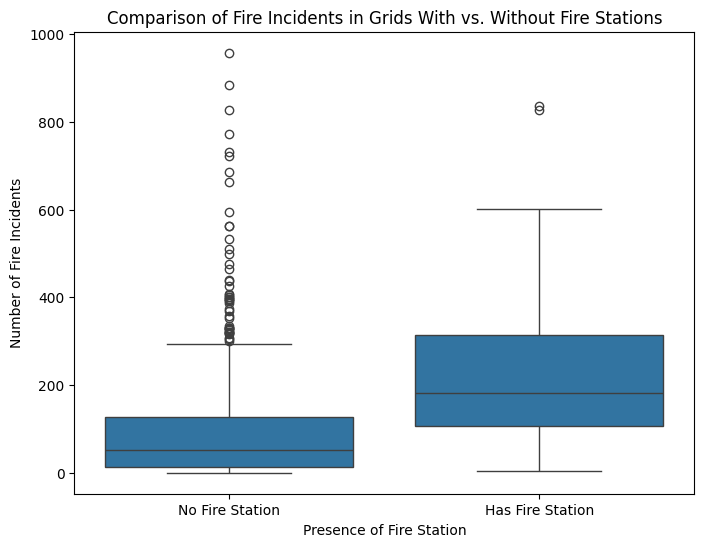

In [ ]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Define file paths
fire_file = "/content/incidents-clean.csv"
caserne_file = "/content/casernes (1).csv"
grid_file = "/content/sqrc_1000 (1).geojson"

# Load the datasets
df_fires = pd.read_csv(fire_file)
df_caserne = pd.read_csv(caserne_file)
grid_gdf = gpd.read_file(grid_file)

# Drop missing lat/lon values
df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])
df_caserne = df_caserne.dropna(subset=["LATITUDE", "LONGITUDE"])

# Convert to GeoDataFrames
df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

df_caserne["geometry"] = df_caserne.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_caserne_gdf = gpd.GeoDataFrame(df_caserne, geometry="geometry", crs="EPSG:4326")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Spatial Join: Assign Fire Stations and Fire Incidents to Grid Squares
caserne_with_grid = gpd.sjoin(df_caserne_gdf, grid_gdf, how="left", predicate="within")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="within")

# Rename `index_right` if it exists
if "index_right" in caserne_with_grid.columns:
    caserne_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)
if "index_right" in fires_with_grid.columns:
    fires_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)

# Aggregate Data: Count Fire Incidents Per Grid
fire_counts = fires_with_grid.groupby("grid_id").size().rename("fire_count").reset_index()

# Merge Fire Incident Data with Grid (INCLUDING GRIDS WITHOUT FIRE STATIONS)
grid_gdf = grid_gdf.merge(fire_counts, left_index=True, right_on="grid_id", how="left")

# Fill missing values (grids without fire incidents should be 0)
grid_gdf["fire_count"] = grid_gdf["fire_count"].fillna(0)

# Create Fire Station Presence Column
grid_gdf["has_fire_station"] = grid_gdf["grid_id"].isin(caserne_with_grid["grid_id"]).astype(int)

# **BOX PLOT: Comparing Fire Incidents in Grids With vs. Without Fire Stations**
plt.figure(figsize=(8, 6))
sns.boxplot(x=grid_gdf["has_fire_station"], y=grid_gdf["fire_count"])
plt.xticks([0, 1], ["No Fire Station", "Has Fire Station"])
plt.xlabel("Presence of Fire Station")
plt.ylabel("Number of Fire Incidents")
plt.title("Comparison of Fire Incidents in Grids With vs. Without Fire Stations")
plt.show()


                            OLS Regression Results                            
Dep. Variable:          NOMBRE_UNITES   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     39.32
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           3.62e-10
Time:                        03:16:13   Log-Likelihood:            -3.2185e+05
No. Observations:               93801   AIC:                         6.437e+05
Df Residuals:                   93799   BIC:                         6.437e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.2323      0.02

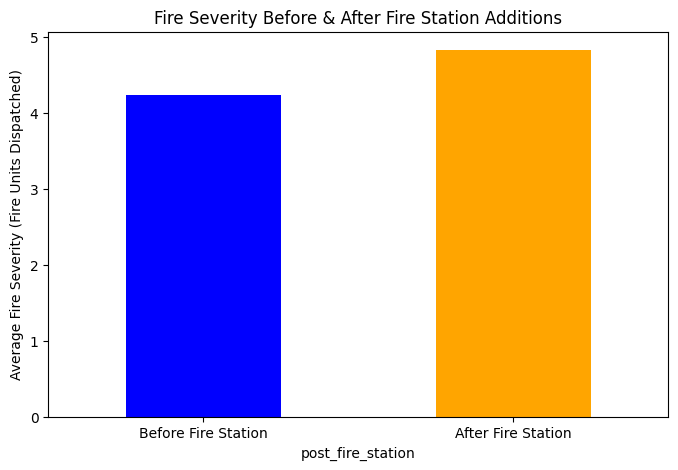

📊 Pearson Correlation (Fire Stations vs. Fire Incidents): 0.6891 (p-value: 0.0000)


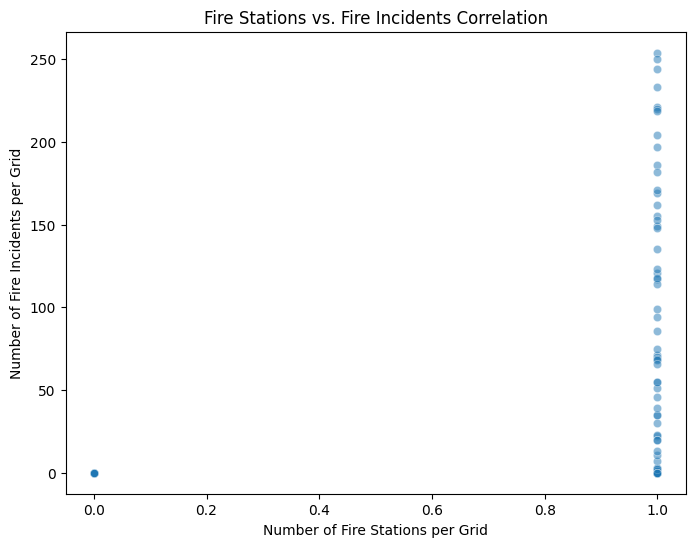

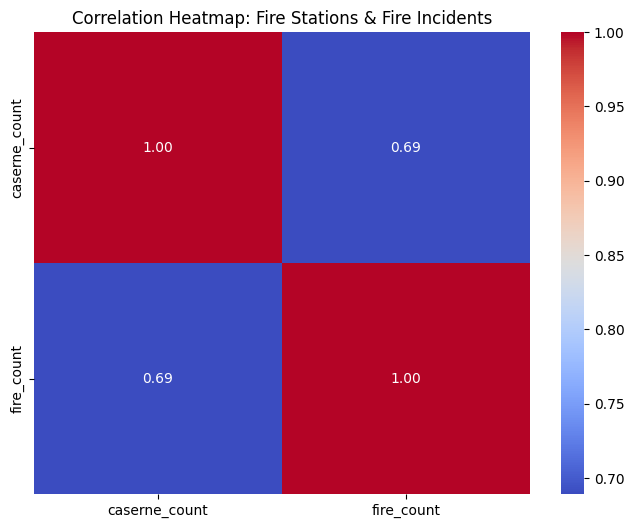

                            OLS Regression Results                            
Dep. Variable:             fire_count   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     807.5
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          4.92e-127
Time:                        03:16:14   Log-Likelihood:                -4043.9
No. Observations:                 895   AIC:                             8092.
Df Residuals:                     893   BIC:                             8101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9.843e-16      0.772   1.27e-15

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import statsmodels.api as sm
from scipy.stats import pearsonr

# Load Fire Station (Caserne) and Fire Incident Datasets
fire_file = "/content/incidents-clean.csv"
caserne_file = "/content/casernes (1).csv"
grid_file = "/content/sqrc_1000 (1).geojson"

df_caserne = pd.read_csv(caserne_file)
df_fires = pd.read_csv(fire_file)
grid_gdf = gpd.read_file(grid_file)

# Drop missing latitude/longitude before spatial analysis
df_caserne = df_caserne.dropna(subset=["LATITUDE", "LONGITUDE"])
df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])

# Convert to GeoDataFrames
df_caserne["geometry"] = df_caserne.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_caserne_gdf = gpd.GeoDataFrame(df_caserne, geometry="geometry", crs="EPSG:4326")

df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

# Convert Date Columns to Datetime
df_caserne["DATE_DEBUT"] = pd.to_datetime(df_caserne["DATE_DEBUT"], errors="coerce")
df_fires["CREATION_DATE"] = pd.to_datetime(df_fires["CREATION_DATE"], errors="coerce")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Spatial Join: Assign Fire Stations and Fire Incidents to Grid Squares
caserne_with_grid = gpd.sjoin(df_caserne_gdf, grid_gdf, how="left", predicate="within")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="within")

# Rename `index_right` to `grid_id` for clarity
caserne_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)
fires_with_grid.rename(columns={"index_right": "grid_id"}, inplace=True)

# Aggregate Fire Stations & Fire Incidents Per Grid
caserne_counts = caserne_with_grid.groupby("grid_id").size().rename("caserne_count").reset_index()
fire_counts = fires_with_grid.groupby("grid_id").size().rename("fire_count").reset_index()

# Merge Data with Grid
grid_gdf = grid_gdf.merge(caserne_counts, left_index=True, right_on="grid_id", how="left")
grid_gdf = grid_gdf.merge(fire_counts, left_index=True, right_on="grid_id", how="left")

# Fill NaN values (some grids may have no fire stations or fires)
grid_gdf["caserne_count"] = grid_gdf["caserne_count"].fillna(0)
grid_gdf["fire_count"] = grid_gdf["fire_count"].fillna(0)

# Ensure Each Fire Matches a Fire Station in the Same Grid
fires_with_grid = fires_with_grid.merge(
    caserne_with_grid[["grid_id", "DATE_DEBUT"]], on="grid_id", how="left"
)

# Create 'post_fire_station' Column (1 = After Fire Station Was Added, 0 = Before)
fires_with_grid["post_fire_station"] = (fires_with_grid["CREATION_DATE"] >= fires_with_grid["DATE_DEBUT"]).astype(int)

# **Drop NaNs to avoid errors in regression**
fires_with_grid = fires_with_grid.dropna(subset=["NOMBRE_UNITES", "post_fire_station"])

### ** causality Analysis: Fire Severity Before & After Fire Stations**
X = sm.add_constant(fires_with_grid[["post_fire_station"]])  # Independent Variable
y = fires_with_grid["NOMBRE_UNITES"]  # Dependent Variable (Fire severity)

# **Run the regression model**
model = sm.OLS(y, X).fit()
print(model.summary())

# Plot Fire Severity Before & After Fire Stations
plt.figure(figsize=(8, 5))
fires_with_grid.groupby("post_fire_station")["NOMBRE_UNITES"].mean().plot(kind="bar", color=["blue", "orange"])
plt.xticks(ticks=[0, 1], labels=["Before Fire Station", "After Fire Station"], rotation=0)
plt.ylabel("Average Fire Severity (Fire Units Dispatched)")
plt.title("Fire Severity Before & After Fire Station Additions")
plt.show()

### **2️Correlation: Fire Stations & Fire Incidents**
#  Compute Pearson Correlation
correlation, p_value = pearsonr(grid_gdf["caserne_count"], grid_gdf["fire_count"])
print(f"Pearson Correlation (Fire Stations vs. Fire Incidents): {correlation:.4f} (p-value: {p_value:.4f})")

# Scatter Plot: Fire Stations vs. Fire Incidents
plt.figure(figsize=(8, 6))
sns.scatterplot(x=grid_gdf["caserne_count"], y=grid_gdf["fire_count"], alpha=0.5)
plt.xlabel("Number of Fire Stations per Grid")
plt.ylabel("Number of Fire Incidents per Grid")
plt.title("Fire Stations vs. Fire Incidents Correlation")
plt.show()

# Heatmap of Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(grid_gdf[["caserne_count", "fire_count"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Fire Stations & Fire Incidents")
plt.show()

# Regression Analysis: Predict Fire Incidents Based on Fire Stations
X = sm.add_constant(grid_gdf["caserne_count"])  # Independent Variable
y = grid_gdf["fire_count"]  # Dependent Variable

model = sm.OLS(y, X).fit()
print(model.summary())
